In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.functional as F
from torchvision import datasets

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
Train_images = np.load('/content/drive/My Drive/RBCDSAI/Experiment1/Datasets/Colored Background MNIST/train2_images.npy')
Train_labels = np.load('/content/drive/My Drive/RBCDSAI/Experiment1/Datasets/Colored Background MNIST/train2_labels.npy')

Test_images = np.load('/content/drive/My Drive/RBCDSAI/Experiment1/Datasets/Colored Background MNIST/test1_images.npy')
Test_labels = np.load('/content/drive/My Drive/RBCDSAI/Experiment1/Datasets/Colored Background MNIST/test1_labels.npy')

mean = np.mean(Train_images, axis = (0,1,2))
std = np.std(Train_images, axis = (0,1,2))

Train_images = (Train_images.astype(np.float32) - np.array(mean) ) / np.array(std)
Test_images = (Test_images.astype(np.float32) - np.array(mean) ) / np.array(std)



In [ ]:
print(Test_images.shape, Train_images.shape)

(10000, 28, 28, 3) (60000, 28, 28, 3)


In [ ]:
Train_images_tensor = torch.tensor(Train_images, dtype = torch.float32)
Test_images_tensor = torch.tensor(Test_images, dtype = torch.float32)

Train_labels_tensor = torch.tensor(Train_labels, dtype = torch.long)
Test_labels_tensor = torch.tensor(Test_labels, dtype = torch.long)


train_dataset = TensorDataset(Train_images_tensor, Train_labels_tensor)
test_dataset = TensorDataset(Test_images_tensor, Test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

In [ ]:
torch.manual_seed(7)


class MLP(nn.Module):
  def __init__(self,input_size, output_size):
    super(MLP,self).__init__()

    self.linear1 = nn.Linear(input_size, 512)
    self.linear2 = nn.Linear(512, 128)
    self.linear3 = nn.Linear(128, output_size)

  def forward(self,x):
    x = x.view(x.size(0), -1)
    x1 = torch.relu(self.linear1(x))
    x2 = torch.relu(self.linear2(x1))
    return self.linear3(x2)

In [ ]:
def train(model, train_loader, optimizer, criterion):
  train_predictions = []
  true_labels = []
  model.train()
  total_train_loss = 0
  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    total_train_loss += loss.item()

    _ , predicted = torch.max(outputs, 1)
    train_predictions.extend(predicted.tolist())
    true_labels.extend(labels.tolist())

  accuracy = accuracy_score(true_labels,train_predictions)
  avg_loss = total_train_loss/len(train_loader)
  return accuracy, avg_loss

def evaluate(model, test_loader, criterion):
  model.eval()
  with torch.no_grad():
    test_predictions = []
    true_labels = []
    total_test_loss = 0
    for inputs, labels in test_loader:
      outputs = model(inputs)
      test_loss = criterion(outputs, labels)
      total_test_loss += test_loss.item()

      _ , predicted = torch.max(outputs, 1)
      test_predictions.extend(predicted.tolist())
      true_labels.extend(labels.tolist())

    accuracy = accuracy_score(true_labels, test_predictions)
    avg_loss = total_test_loss / len(test_loader)
    return accuracy, avg_loss

Learning Rate: 0.05
>>epoch: 0 Train_accuracy: 0.4938, Train_loss: 0.7016, Test_accuracy: 0.4937, Test_loss: 0.7101
>>epoch: 0 Train_accuracy: 0.6786, Train_loss: 0.6195, Test_accuracy: 0.6774, Test_loss: 0.6220
>>epoch: 1 Train_accuracy: 0.7168, Train_loss: 0.5927, Test_accuracy: 0.7079, Test_loss: 0.6034
>>epoch: 2 Train_accuracy: 0.7248, Train_loss: 0.5849, Test_accuracy: 0.6690, Test_loss: 0.6320
>>epoch: 3 Train_accuracy: 0.7288, Train_loss: 0.5792, Test_accuracy: 0.7132, Test_loss: 0.6018
>>epoch: 4 Train_accuracy: 0.7327, Train_loss: 0.5742, Test_accuracy: 0.7049, Test_loss: 0.6022
>>epoch: 5 Train_accuracy: 0.7344, Train_loss: 0.5698, Test_accuracy: 0.7226, Test_loss: 0.5926
>>epoch: 6 Train_accuracy: 0.7378, Train_loss: 0.5661, Test_accuracy: 0.7151, Test_loss: 0.5967
>>epoch: 7 Train_accuracy: 0.7383, Train_loss: 0.5615, Test_accuracy: 0.7001, Test_loss: 0.6101
>>epoch: 8 Train_accuracy: 0.7406, Train_loss: 0.5582, Test_accuracy: 0.7046, Test_loss: 0.6079
>>epoch: 9 Train_acc

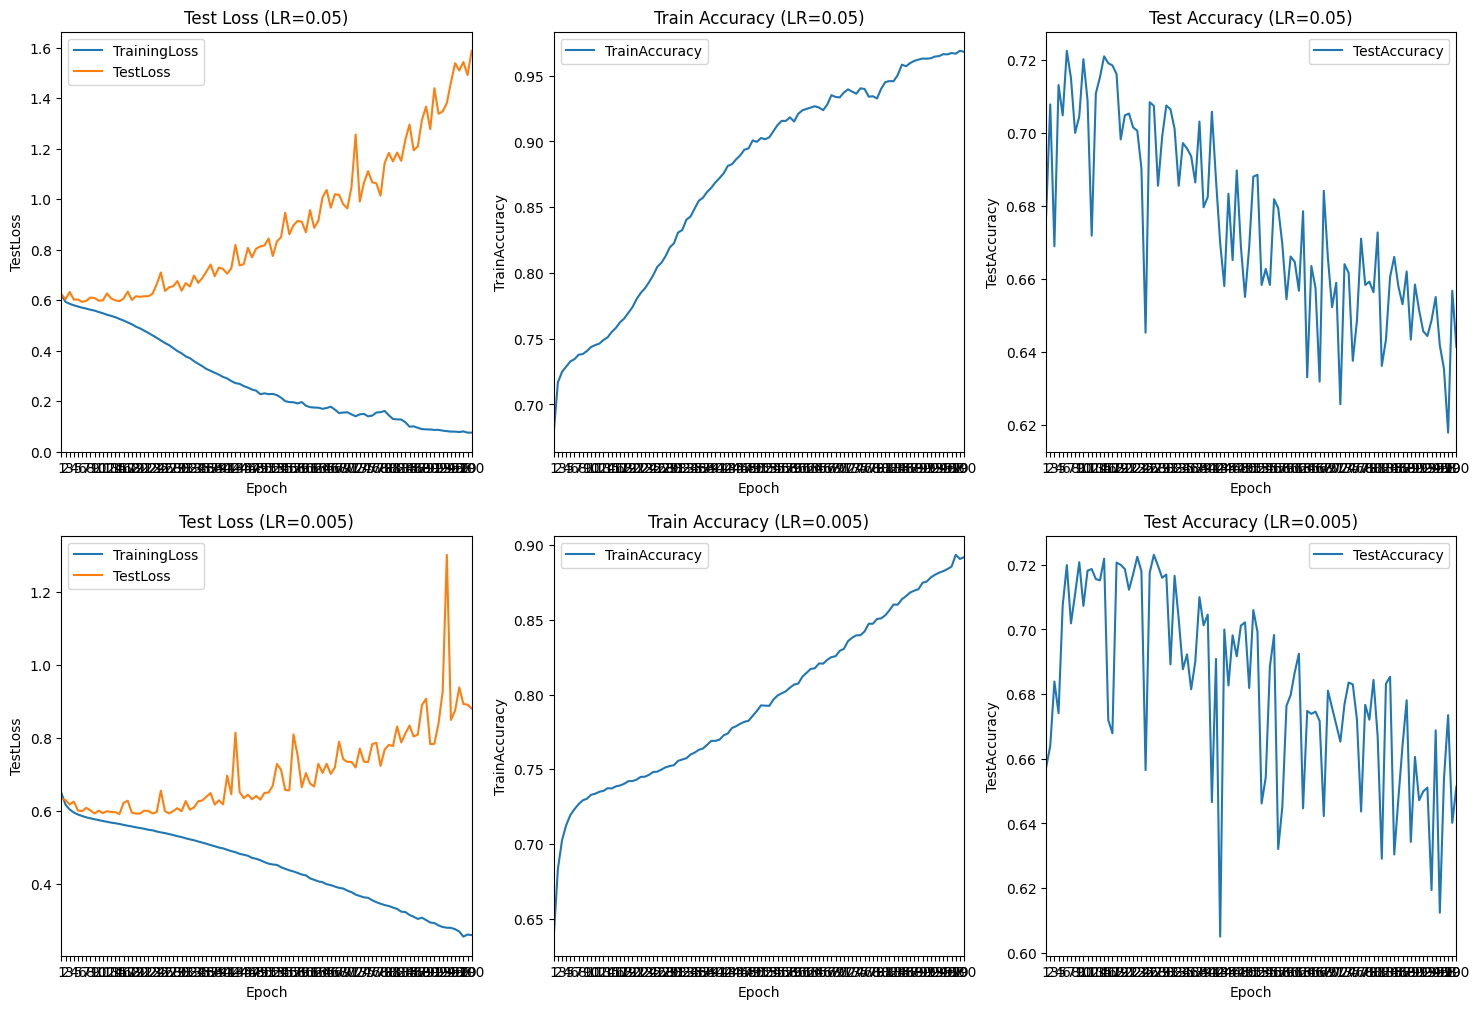

In [ ]:
rates = [0.05, 0.005]
inputsize = Train_images.shape[1]*Train_images.shape[2]*Train_images.shape[3]
outputsize = 2

num_epochs = 100
loss_threshold = 0.05

fig, axs = plt.subplots(len(rates), 3, figsize=(18, 6 * len(rates)))

for i,l_rate in enumerate(rates):
  train_accuracies = []
  test_accuracies = []
  train_loss = []
  test_loss = []
  print("Learning Rate:",l_rate)

  model = MLP(inputsize, outputsize)
  optimizer = optim.SGD(model.parameters(),lr = l_rate)
  criterion = nn.CrossEntropyLoss()

  test_accuracy, testing_loss = evaluate(model, test_loader, criterion)
  training_accuracy, training_loss = evaluate(model, train_loader, criterion)
  epoch=0
  print(">>epoch: {} Train_accuracy: {:.4f}, Train_loss: {:.4f}, Test_accuracy: {:.4f}, Test_loss: {:.4f}".format(epoch, training_accuracy, training_loss, test_accuracy, testing_loss))

  for epoch in range(num_epochs):

    train_accuracy, training_loss = train(model, train_loader, optimizer, criterion)
    test_accuracy, testing_loss = evaluate(model, test_loader, criterion)

    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)

    train_loss.append(training_loss)
    test_loss.append(testing_loss)


    if training_loss < loss_threshold:
        print(f"Training stopped early at epoch {epoch + 1} due to training loss below threshold ({training_loss:.4f} < {loss_threshold})")
        break


    print(">>epoch: {} Train_accuracy: {:.4f}, Train_loss: {:.4f}, Test_accuracy: {:.4f}, Test_loss: {:.4f}".format(epoch, train_accuracy, training_loss, test_accuracy, testing_loss))

  epochs = list(range(1, num_epochs + 1))
  axs[i,0].plot(epochs, train_loss, label = 'TrainingLoss')
  axs[i,0].set_xlabel('Epoch')
  axs[i,0].set_ylabel('TrainingLoss')
  axs[i,0].set_title(f'Training Loss (LR={l_rate})')
  axs[i,0].legend()
  axs[i,0].set_xticks(epochs)
  axs[i,0].set_xlim(1,num_epochs)

  axs[i,0].plot(epochs, test_loss, label = 'TestLoss')
  axs[i,0].set_xlabel('Epoch')
  axs[i,0].set_ylabel('TestLoss')
  axs[i,0].set_title(f'Test Loss (LR={l_rate})')
  axs[i,0].legend()
  axs[i,0].set_xticks(epochs)
  axs[i,0].set_xlim(1,num_epochs)

  axs[i,1].plot(epochs, train_accuracies, label = 'TrainAccuracy')
  axs[i,1].set_xlabel('Epoch')
  axs[i,1].set_ylabel('TrainAccuracy')
  axs[i,1].set_title(f'Train Accuracy (LR={l_rate})')
  axs[i,1].legend()
  axs[i,1].set_xticks(epochs)
  axs[i,1].set_xlim(1,num_epochs)


  axs[i,2].plot(epochs, test_accuracies, label = 'TestAccuracy')
  axs[i,2].set_xlabel('Epoch')
  axs[i,2].set_ylabel('TestAccuracy')
  axs[i,2].set_title(f'Test Accuracy (LR={l_rate})')
  axs[i,2].legend()
  axs[i,2].set_xticks(epochs)
  axs[i,2].set_xlim(1,num_epochs)


##SGD with Decay

Learning Rate: 0.05
>>epoch: 0 Train_accuracy: 0.5215, Train_loss: 0.6923, Test_accuracy: 0.5055, Test_loss: 0.6967
>>epoch: 0 Train_accuracy: 0.6818, Train_loss: 0.6175, Test_accuracy: 0.6744, Test_loss: 0.6240
>>epoch: 1 Train_accuracy: 0.7161, Train_loss: 0.5938, Test_accuracy: 0.7073, Test_loss: 0.6037
>>epoch: 2 Train_accuracy: 0.7243, Train_loss: 0.5859, Test_accuracy: 0.7105, Test_loss: 0.5990
>>epoch: 3 Train_accuracy: 0.7285, Train_loss: 0.5805, Test_accuracy: 0.7160, Test_loss: 0.5968
>>epoch: 4 Train_accuracy: 0.7319, Train_loss: 0.5768, Test_accuracy: 0.7134, Test_loss: 0.5952
>>epoch: 5 Train_accuracy: 0.7334, Train_loss: 0.5738, Test_accuracy: 0.6208, Test_loss: 0.6721
>>epoch: 6 Train_accuracy: 0.7347, Train_loss: 0.5709, Test_accuracy: 0.7229, Test_loss: 0.5952
>>epoch: 7 Train_accuracy: 0.7366, Train_loss: 0.5678, Test_accuracy: 0.7214, Test_loss: 0.5940
>>epoch: 8 Train_accuracy: 0.7374, Train_loss: 0.5655, Test_accuracy: 0.7174, Test_loss: 0.5932
>>epoch: 9 Train_acc

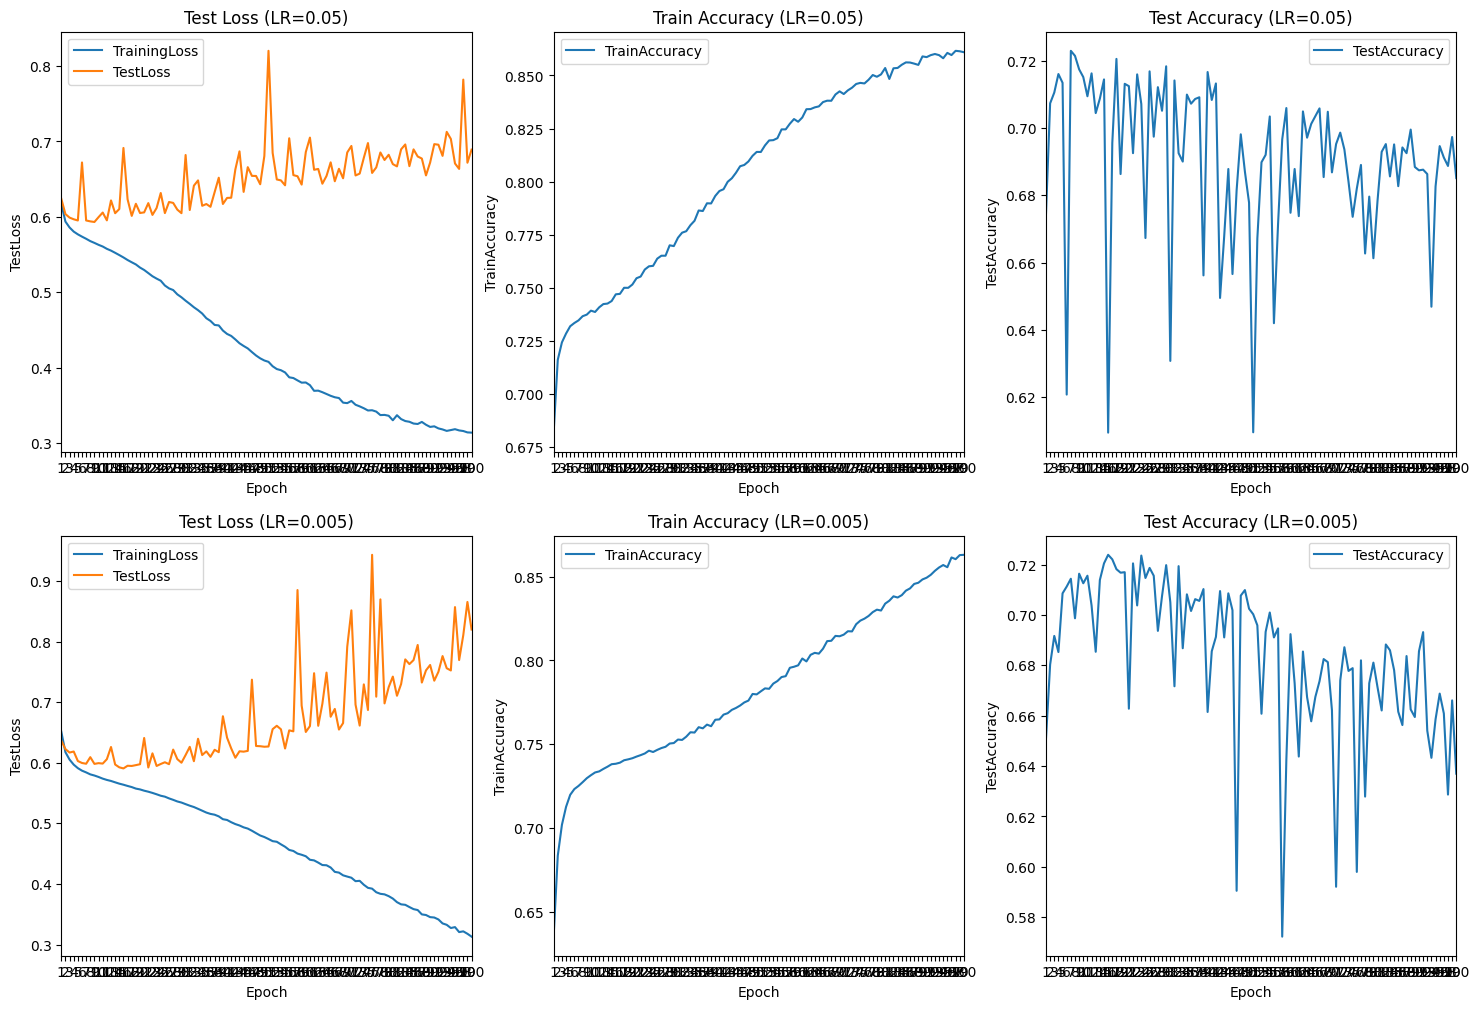

In [ ]:
rates = [0.05, 0.005]
inputsize = Train_images.shape[1]*Train_images.shape[2]*Train_images.shape[3]
outputsize = 2

num_epochs = 100
loss_threshold = 0.05

fig, axs = plt.subplots(len(rates), 3, figsize=(18, 6 * len(rates)))

for i,l_rate in enumerate(rates):
  train_accuracies = []
  test_accuracies = []
  train_loss = []
  test_loss = []
  print("Learning Rate:",l_rate)

  model = MLP(inputsize, outputsize)
  optimizer = optim.SGD(model.parameters(),lr = l_rate,weight_decay = 0.001)
  criterion = nn.CrossEntropyLoss()

  test_accuracy, testing_loss = evaluate(model, test_loader, criterion)
  training_accuracy, training_loss = evaluate(model, train_loader, criterion)
  epoch=0
  print(">>epoch: {} Train_accuracy: {:.4f}, Train_loss: {:.4f}, Test_accuracy: {:.4f}, Test_loss: {:.4f}".format(epoch, training_accuracy, training_loss, test_accuracy, testing_loss))

  for epoch in range(num_epochs):

    train_accuracy, training_loss = train(model, train_loader, optimizer, criterion)
    test_accuracy, testing_loss = evaluate(model, test_loader, criterion)

    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)

    train_loss.append(training_loss)
    test_loss.append(testing_loss)

    if training_loss < loss_threshold:
        print(f"Training stopped early at epoch {epoch + 1} due to training loss below threshold ({training_loss:.4f} < {loss_threshold})")
        break

    print(">>epoch: {} Train_accuracy: {:.4f}, Train_loss: {:.4f}, Test_accuracy: {:.4f}, Test_loss: {:.4f}".format(epoch, train_accuracy, training_loss, test_accuracy, testing_loss))

  epochs = list(range(1, num_epochs + 1))
  axs[i,0].plot(epochs, train_loss, label = 'TrainingLoss')
  axs[i,0].set_xlabel('Epoch')
  axs[i,0].set_ylabel('TrainingLoss')
  axs[i,0].set_title(f'Training Loss (LR={l_rate})')
  axs[i,0].legend()
  axs[i,0].set_xticks(epochs)
  axs[i,0].set_xlim(1,num_epochs)

  axs[i,0].plot(epochs, test_loss, label = 'TestLoss')
  axs[i,0].set_xlabel('Epoch')
  axs[i,0].set_ylabel('TestLoss')
  axs[i,0].set_title(f'Test Loss (LR={l_rate})')
  axs[i,0].legend()
  axs[i,0].set_xticks(epochs)
  axs[i,0].set_xlim(1,num_epochs)

  axs[i,1].plot(epochs, train_accuracies, label = 'TrainAccuracy')
  axs[i,1].set_xlabel('Epoch')
  axs[i,1].set_ylabel('TrainAccuracy')
  axs[i,1].set_title(f'Train Accuracy (LR={l_rate})')
  axs[i,1].legend()
  axs[i,1].set_xticks(epochs)
  axs[i,1].set_xlim(1,num_epochs)


  axs[i,2].plot(epochs, test_accuracies, label = 'TestAccuracy')
  axs[i,2].set_xlabel('Epoch')
  axs[i,2].set_ylabel('TestAccuracy')
  axs[i,2].set_title(f'Test Accuracy (LR={l_rate})')
  axs[i,2].legend()
  axs[i,2].set_xticks(epochs)
  axs[i,2].set_xlim(1,num_epochs)


##SGD with Momentum

Learning Rate: 0.05
>>epoch: 0 Train_accuracy: 0.5036, Train_loss: 0.6947, Test_accuracy: 0.5037, Test_loss: 0.6974
>>epoch: 0 Train_accuracy: 0.6683, Train_loss: 0.6330, Test_accuracy: 0.5260, Test_loss: 0.7060
>>epoch: 1 Train_accuracy: 0.6967, Train_loss: 0.6148, Test_accuracy: 0.6845, Test_loss: 0.6310
>>epoch: 2 Train_accuracy: 0.7065, Train_loss: 0.6053, Test_accuracy: 0.6212, Test_loss: 0.7683
>>epoch: 3 Train_accuracy: 0.7081, Train_loss: 0.6007, Test_accuracy: 0.5345, Test_loss: 0.6679
>>epoch: 4 Train_accuracy: 0.7154, Train_loss: 0.5956, Test_accuracy: 0.6973, Test_loss: 0.6317
>>epoch: 5 Train_accuracy: 0.7167, Train_loss: 0.5909, Test_accuracy: 0.6771, Test_loss: 0.6197
>>epoch: 6 Train_accuracy: 0.7216, Train_loss: 0.5881, Test_accuracy: 0.6845, Test_loss: 0.6156
>>epoch: 7 Train_accuracy: 0.7258, Train_loss: 0.5814, Test_accuracy: 0.6818, Test_loss: 0.6191
>>epoch: 8 Train_accuracy: 0.7292, Train_loss: 0.5782, Test_accuracy: 0.6514, Test_loss: 0.6342
>>epoch: 9 Train_acc

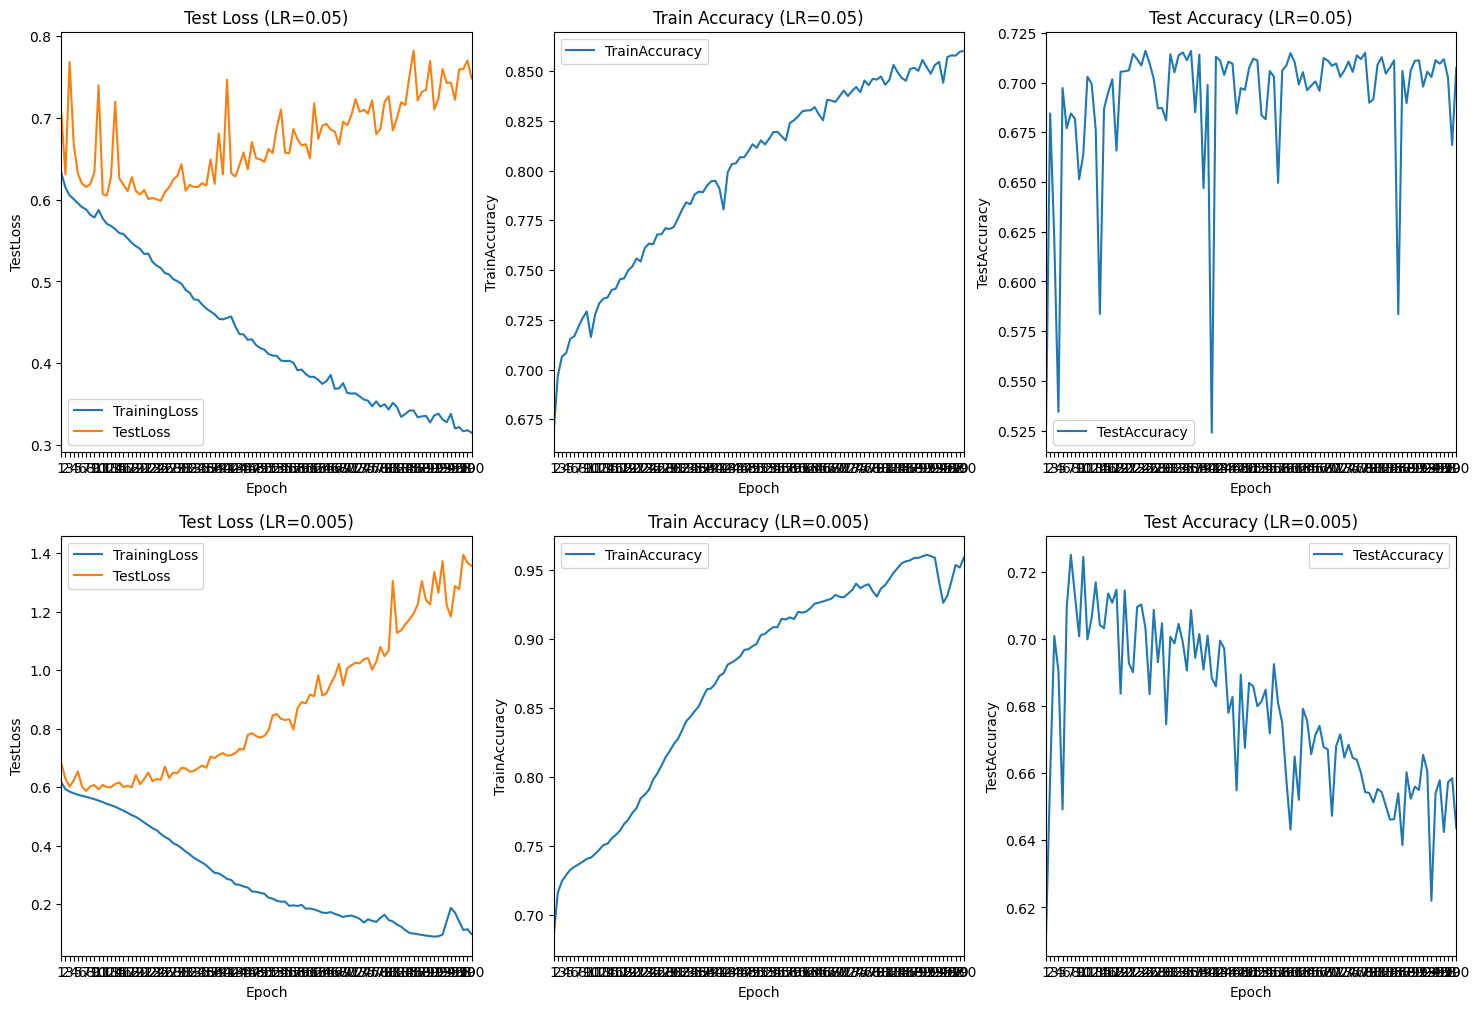

In [ ]:
rates = [0.05, 0.005]
inputsize = Train_images.shape[1]*Train_images.shape[2]*Train_images.shape[3]
outputsize = 2

num_epochs = 100
loss_threshold = 0.05

fig, axs = plt.subplots(len(rates), 3, figsize=(18, 6 * len(rates)))

for i,l_rate in enumerate(rates):
  train_accuracies = []
  test_accuracies = []
  train_loss = []
  test_loss = []
  print("Learning Rate:",l_rate)

  model = MLP(inputsize, outputsize)
  optimizer = optim.SGD(model.parameters(),lr = l_rate, momentum = 0.9)
  criterion = nn.CrossEntropyLoss()

  test_accuracy, testing_loss = evaluate(model, test_loader, criterion)
  training_accuracy, training_loss = evaluate(model, train_loader, criterion)
  epoch=0
  print(">>epoch: {} Train_accuracy: {:.4f}, Train_loss: {:.4f}, Test_accuracy: {:.4f}, Test_loss: {:.4f}".format(epoch, training_accuracy, training_loss, test_accuracy, testing_loss))

  for epoch in range(num_epochs):

    train_accuracy, training_loss = train(model, train_loader, optimizer, criterion)
    test_accuracy, testing_loss = evaluate(model, test_loader, criterion)

    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)

    train_loss.append(training_loss)
    test_loss.append(testing_loss)

    if training_loss < loss_threshold:
        print(f"Training stopped early at epoch {epoch + 1} due to training loss below threshold ({training_loss:.4f} < {loss_threshold})")
        break

    print(">>epoch: {} Train_accuracy: {:.4f}, Train_loss: {:.4f}, Test_accuracy: {:.4f}, Test_loss: {:.4f}".format(epoch, train_accuracy, training_loss, test_accuracy, testing_loss))

  epochs = list(range(1, num_epochs + 1))
  axs[i,0].plot(epochs, train_loss, label = 'TrainingLoss')
  axs[i,0].set_xlabel('Epoch')
  axs[i,0].set_ylabel('TrainingLoss')
  axs[i,0].set_title(f'Training Loss (LR={l_rate})')
  axs[i,0].legend()
  axs[i,0].set_xticks(epochs)
  axs[i,0].set_xlim(1,num_epochs)

  axs[i,0].plot(epochs, test_loss, label = 'TestLoss')
  axs[i,0].set_xlabel('Epoch')
  axs[i,0].set_ylabel('TestLoss')
  axs[i,0].set_title(f'Test Loss (LR={l_rate})')
  axs[i,0].legend()
  axs[i,0].set_xticks(epochs)
  axs[i,0].set_xlim(1,num_epochs)

  axs[i,1].plot(epochs, train_accuracies, label = 'TrainAccuracy')
  axs[i,1].set_xlabel('Epoch')
  axs[i,1].set_ylabel('TrainAccuracy')
  axs[i,1].set_title(f'Train Accuracy (LR={l_rate})')
  axs[i,1].legend()
  axs[i,1].set_xticks(epochs)
  axs[i,1].set_xlim(1,num_epochs)


  axs[i,2].plot(epochs, test_accuracies, label = 'TestAccuracy')
  axs[i,2].set_xlabel('Epoch')
  axs[i,2].set_ylabel('TestAccuracy')
  axs[i,2].set_title(f'Test Accuracy (LR={l_rate})')
  axs[i,2].legend()
  axs[i,2].set_xticks(epochs)
  axs[i,2].set_xlim(1,num_epochs)


##Momentum with Weight Decay

Learning Rate: 0.05
>>epoch: 0 Train_accuracy: 0.4633, Train_loss: 0.7027, Test_accuracy: 0.4888, Test_loss: 0.7174
>>epoch: 0 Train_accuracy: 0.6657, Train_loss: 0.6327, Test_accuracy: 0.6442, Test_loss: 0.6481
>>epoch: 1 Train_accuracy: 0.6882, Train_loss: 0.6188, Test_accuracy: 0.5694, Test_loss: 0.6581
>>epoch: 2 Train_accuracy: 0.6929, Train_loss: 0.6131, Test_accuracy: 0.5959, Test_loss: 0.6812
>>epoch: 3 Train_accuracy: 0.6939, Train_loss: 0.6121, Test_accuracy: 0.6901, Test_loss: 0.6163
>>epoch: 4 Train_accuracy: 0.6982, Train_loss: 0.6079, Test_accuracy: 0.6958, Test_loss: 0.6122
>>epoch: 5 Train_accuracy: 0.6918, Train_loss: 0.6113, Test_accuracy: 0.5257, Test_loss: 0.7405
>>epoch: 6 Train_accuracy: 0.6966, Train_loss: 0.6083, Test_accuracy: 0.5877, Test_loss: 0.6861
>>epoch: 7 Train_accuracy: 0.6812, Train_loss: 0.6142, Test_accuracy: 0.5247, Test_loss: 0.6850
>>epoch: 8 Train_accuracy: 0.6903, Train_loss: 0.6124, Test_accuracy: 0.5256, Test_loss: 0.6895
>>epoch: 9 Train_acc

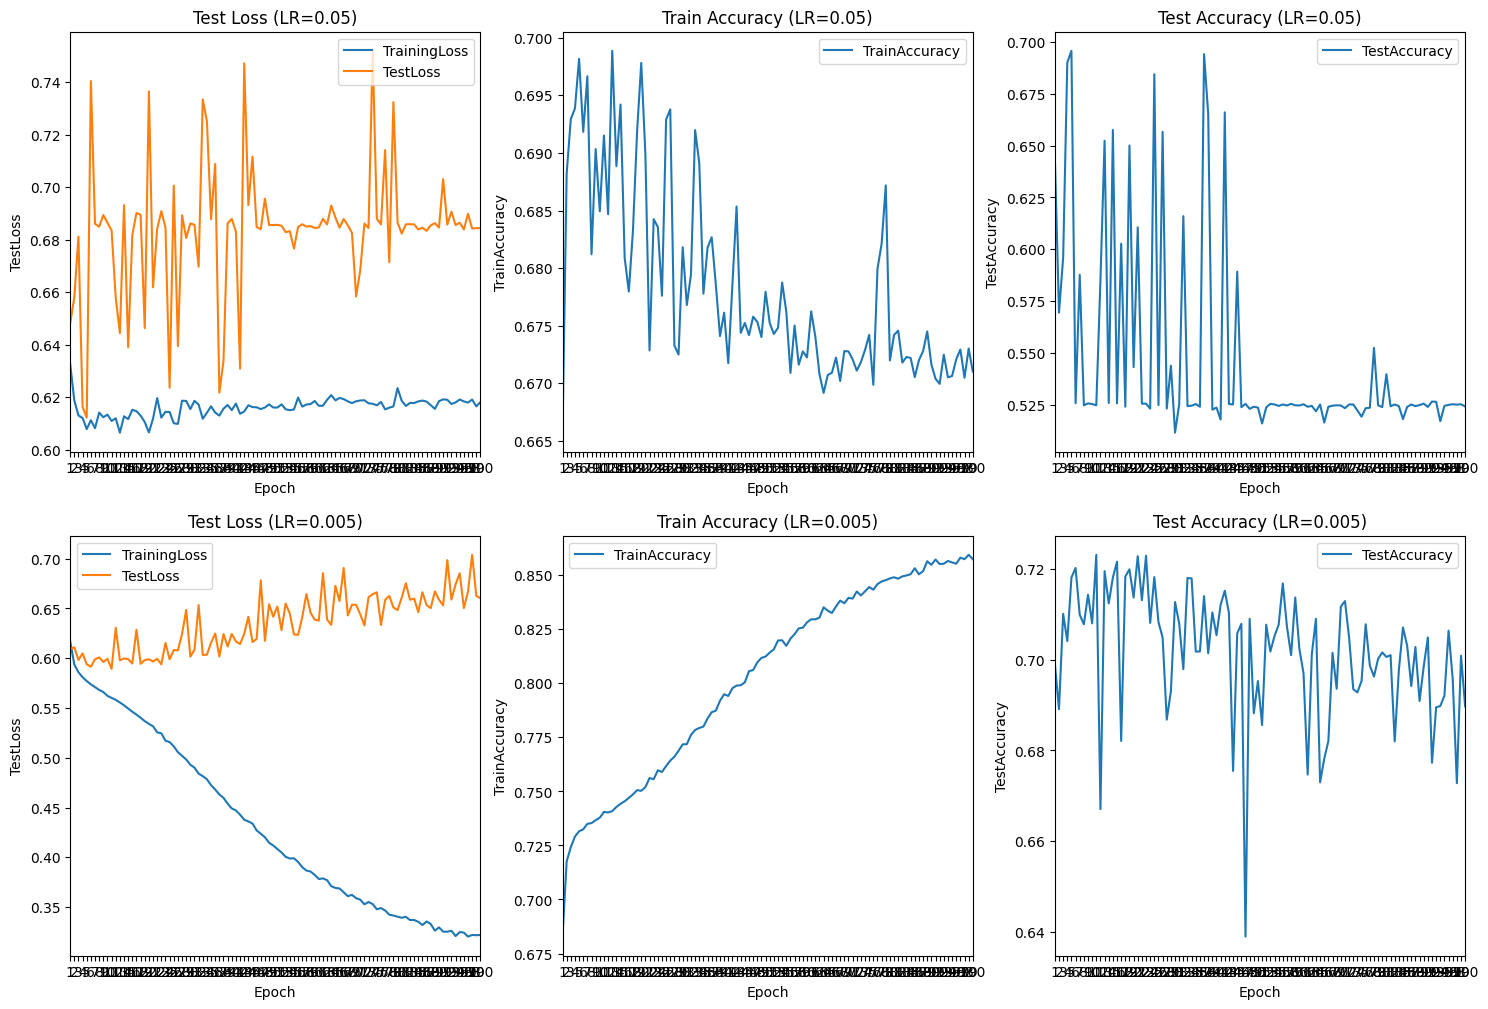

In [ ]:
rates = [0.05, 0.005]
inputsize = Train_images.shape[1]*Train_images.shape[2]*Train_images.shape[3]
outputsize = 2

num_epochs = 100
loss_threshold = 0.05

fig, axs = plt.subplots(len(rates), 3, figsize=(18, 6 * len(rates)))

for i,l_rate in enumerate(rates):
  train_accuracies = []
  test_accuracies = []
  train_loss = []
  test_loss = []
  print("Learning Rate:",l_rate)

  model = MLP(inputsize, outputsize)
  optimizer = optim.SGD(model.parameters(),lr = l_rate, momentum = 0.9, weight_decay = 0.001)
  criterion = nn.CrossEntropyLoss()

  test_accuracy, testing_loss = evaluate(model, test_loader, criterion)
  training_accuracy, training_loss = evaluate(model, train_loader, criterion)

  if training_loss < loss_threshold:
    print(f"Training stopped early at epoch {epoch + 1} due to training loss below threshold ({training_loss:.4f} < {loss_threshold})")
    break

  epoch=0
  print(">>epoch: {} Train_accuracy: {:.4f}, Train_loss: {:.4f}, Test_accuracy: {:.4f}, Test_loss: {:.4f}".format(epoch, training_accuracy, training_loss, test_accuracy, testing_loss))
  for epoch in range(num_epochs):

    train_accuracy, training_loss = train(model, train_loader, optimizer, criterion)
    test_accuracy, testing_loss = evaluate(model, test_loader, criterion)

    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)

    train_loss.append(training_loss)
    test_loss.append(testing_loss)

    print(">>epoch: {} Train_accuracy: {:.4f}, Train_loss: {:.4f}, Test_accuracy: {:.4f}, Test_loss: {:.4f}".format(epoch, train_accuracy, training_loss, test_accuracy, testing_loss))

  epochs = list(range(1, num_epochs + 1))
  axs[i,0].plot(epochs, train_loss, label = 'TrainingLoss')
  axs[i,0].set_xlabel('Epoch')
  axs[i,0].set_ylabel('TrainingLoss')
  axs[i,0].set_title(f'Training Loss (LR={l_rate})')
  axs[i,0].legend()
  axs[i,0].set_xticks(epochs)
  axs[i,0].set_xlim(1,num_epochs)

  axs[i,0].plot(epochs, test_loss, label = 'TestLoss')
  axs[i,0].set_xlabel('Epoch')
  axs[i,0].set_ylabel('TestLoss')
  axs[i,0].set_title(f'Test Loss (LR={l_rate})')
  axs[i,0].legend()
  axs[i,0].set_xticks(epochs)
  axs[i,0].set_xlim(1,num_epochs)

  axs[i,1].plot(epochs, train_accuracies, label = 'TrainAccuracy')
  axs[i,1].set_xlabel('Epoch')
  axs[i,1].set_ylabel('TrainAccuracy')
  axs[i,1].set_title(f'Train Accuracy (LR={l_rate})')
  axs[i,1].legend()
  axs[i,1].set_xticks(epochs)
  axs[i,1].set_xlim(1,num_epochs)


  axs[i,2].plot(epochs, test_accuracies, label = 'TestAccuracy')
  axs[i,2].set_xlabel('Epoch')
  axs[i,2].set_ylabel('TestAccuracy')
  axs[i,2].set_title(f'Test Accuracy (LR={l_rate})')
  axs[i,2].legend()
  axs[i,2].set_xticks(epochs)
  axs[i,2].set_xlim(1,num_epochs)
